In [1]:
##### Seguindo o tutorial 
##### https://www.tensorflow.org/tutorials/quickstart/advanced


###############
######   Tentar fazer um reshape no inputs para que tenha um canal a mais, e colocar esse canal a mais no lugar do batch_size, para que venha um kernel com tamanho batch_size convoluindo no canal do batch_size do inputs
######   Talvez sera util: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/utils/conv_utils.py
###############



import tensorflow as tf

print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from tqdm import tqdm
from conv2d_adaptive import Conv2d_ada

import numpy as np 
import matplotlib.pyplot as plt


2.3.0


In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

x_train[0:100] *= -1
x_train[0:100] += np.min(x_train[0:100])

x_test[0:10] *= -1
x_test[0:10] += np.min(x_test[0:10])


train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
#train_ds = tf.data.Dataset.from_tensor_slices(
#    (x_train, y_train)).batch(32)#shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


(28, 28, 1)


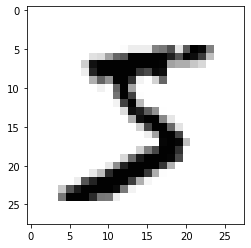

In [3]:
print(x_train[0].shape)
plt.imshow(x_train[0].reshape([28,28]),cmap='gray')

In [4]:
class Modelo_Principal(Model):
  def __init__(self):
    super(Modelo_Principal, self).__init__()
    #####################
    #### Escolhi kernel 7x7 para o conv2d_ada, então o valor que entra nele tem que estar de acordo
    #####################
    self.conv1 = Conv2d_ada(32, 7, activation='relu', use_bias=False)
    #self.conv10 = Conv2d_ada(32, 7, activation='relu', use_bias=False)
    #self.conv100 = Conv2d_ada(32, 7, activation='relu')
    #self.conv1000 = Conv2d_ada(32, 7, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    y = x[1]
    x = x[0]
    #y = tf.reshape(tf.math.reduce_mean(y, axis = [0,-1]), [7,7,1,1])
    
    
    y = tf.reshape(tf.math.reduce_mean(y, axis = 0), [3,3,1,1])


    ## print se você quiser ver o tamanho dos tensores
    #print(x,y)

    ##################### 
    #### Aqui que vem a mágica. a entrada "y" aqui (que é a saída do modelo adaptativo) tem shape = batch_size, 7, 7, n_filtros. Então, fiz uma média nos eixos do batch_size e 
    #### dos filtros, fazendo com que y se tornasse shaper 1, 7, 7, 1. Agora, só preciso passar isso para 7, 7, 1, 1, pois o kernel tem shape 7, 7, 1, 32. Desse jeito, também 
    #### garanto que todos os exemplos do batch são levados em consideração no treinamento, e a rede vira totalmente agnostica ao batch_size. 
    #####################
    #x = self.conv1(x, tf.reshape(tf.math.reduce_mean(y, axis = [0,-1]), [7,7,1,1])) 
    #x = self.conv10(x, tf.reshape(tf.math.reduce_mean(y, axis = [0,-1]), [7,7,1,1])) 
    #x = self.conv100(x, tf.reshape(tf.math.reduce_mean(y, axis = [0,-1]), [7,7,1,1])) 
    #x = self.conv1000(x, tf.reshape(tf.math.reduce_mean(y, axis = [0,-1]), [7,7,1,1])) 

    x = self.conv1(x, y) 
    #x = self.conv10(x, y) 
    #x = self.conv100(x, y) 
    #x = self.conv1000(x, y) 
    
    
    ## tentativas falhas
    #[1,2,2,1]))#tf.reshape(y, [2, 2, 1, x.shape[0]]))
    #tf.reshape(y[0], [2,2,1,1]))#y[0, None])#tf.reshape(y, [2, 2, 1, x.shape[0]]))


    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

class Modelo_Adaptativo(Model):
  def __init__(self):
    super(Modelo_Adaptativo, self).__init__()
    #### Aqui, eu tenho que fazer uma matemágica com os strids para que a saída seja 7x7, como no kernel do modelo principal. Como o input tem 28x28x1, podemos dividir por 4
    #self.conv1 = Conv2D(32, 3, strides=(1,1), activation='relu', padding = 'same')
    #self.conv10 = Conv2D(32, 3, strides=(1,1), activation='relu', padding = 'same')
    #self.conv100 = Conv2D(32, 3, strides=(1,1), activation='relu', padding = 'same')
    #self.conv1000 = Conv2D(32, 3, strides=(1,1), activation='relu', padding = 'same')
    #self.conv10000 = Conv2D(32, 2, strides=(2,2), activation='relu')
    #self.conv2 = Conv2D(32, 2, strides=(2,2), activation=None) ### Saída sigmoid é de extrema importancia. Tahn e ReLU fizeram o resultado ficar pior


    self.conv10000 = Conv2D(32, 7, strides=(7,7), activation='relu')
    self.flatten = Flatten()
    self.d2 = Dense(3*3, activation='relu')

  def call(self, x):
    #x = self.conv1(x)
    #x = self.conv10(x)
    #x = self.conv100(x)
    #x = self.conv1000(x)
    x = self.conv10000(x)
    #x = self.conv2(x)
    x = self.flatten(x)
    x = self.d2(x)
    return x

# Create an instance of the model
model = Modelo_Principal()
model2 = Modelo_Adaptativo()


In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()


In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


In [7]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).

    ### Passar a saída do model2 como a segunda entrada do nosso modelo
    predictions = model([images, model2(images, training=True)], training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


In [8]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model([images, model2(images, training=False)], training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


In [9]:
EPOCHS = 5
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in tqdm(train_ds):
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    #if(test_images.shape[0] == 32):
      test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100))

0%|          | 0/1875 [00:00<?, ?it/s]tf_strides:  [1, 1]
tf_padding:  VALID
tf_dilations:  [1, 1]
self._tf_data_format:  NHWC
 16%|█▌        | 292/1875 [00:04<00:26, 60.58it/s]


KeyboardInterrupt: 

In [68]:
model.conv1.weights[0][:,:,0,0]

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[ 0.037650295 , -0.07479624  , -0.06171885  ,  0.031283673 ,
         0.07495785  ,  0.033473045 ,  0.12171575  ],
       [-0.19029035  , -0.10492013  , -0.03966027  ,  0.025624756 ,
         0.017150914 ,  0.00500977  ,  0.0040065725],
       [-0.14864329  , -0.017206524 ,  0.04964083  , -0.061081138 ,
        -0.04616866  ,  0.05157525  ,  0.062853254 ],
       [ 0.046787616 ,  0.01244659  ,  0.0154962605, -0.08223637  ,
         0.046932574 ,  0.073065616 , -0.034376852 ],
       [ 0.1370269   , -0.050159473 ,  0.053732295 , -0.061575107 ,
        -0.012331999 ,  0.063158326 , -0.014511076 ],
       [ 0.1342297   , -0.03250338  , -0.02345282  , -0.05686473  ,
        -0.053228557 , -0.013570765 ,  0.031168368 ],
       [-0.0154662235, -0.04937304  , -0.004619509 ,  0.0034993512,
        -0.009543615 , -0.120198496 , -0.044108212 ]], dtype=float32)>

In [10]:
import numpy as np
image_id = 18
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
images = x_test[image_id][None,:]
print(y_test[image_id])
predictions =  model2(images)
predictions2 = model([images,model2(images)])
#print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
print(predictions.numpy().reshape([2,2]))

3


ValueError: cannot reshape array of size 9 into shape (2,2)

In [81]:
import numpy as np
image_id = 10
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)
images = x_test[image_id][None,:]
print(y_test[image_id])
predictions =  model2(images)
predictions2 = model([images,model2(images)])
#print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
print(predictions.numpy().reshape([2]))

0
[0.08360527 0.01311058]


In [17]:
import matplotlib.pyplot as plt
count = 0
def plot(a, valor):
    plt.figure()
    plt.imshow(a[0], cmap='gray')
    plt.title('{}'.format(valor))

for n in range(10):
    count = 0
    for x,y in zip(x_test, y_test):
        if(y == n):
            count += 1
            predictions =  model2(x[None,:])
            #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
            plot(tf.math.reduce_mean(predictions, axis=[-1]).numpy(), y)
        if(count == 3):
            break


TypeError: Invalid shape () for image data

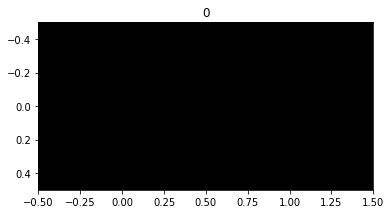

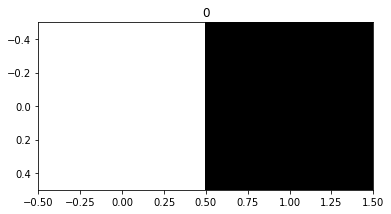

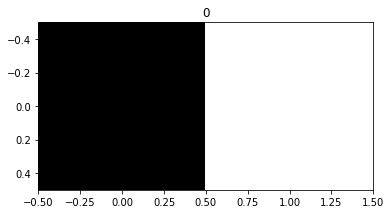

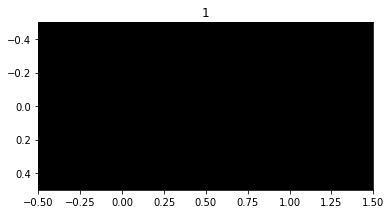

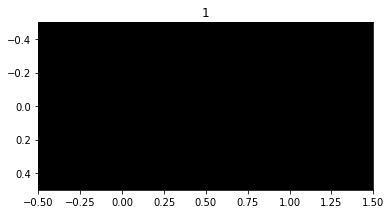

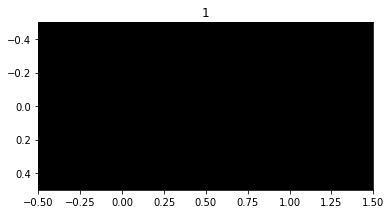

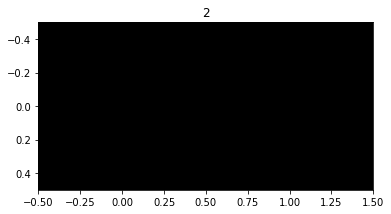

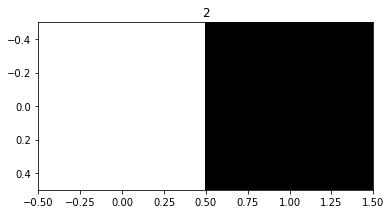

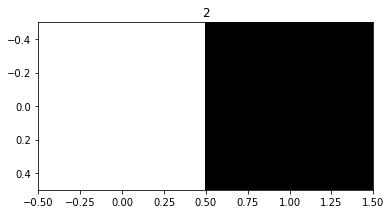

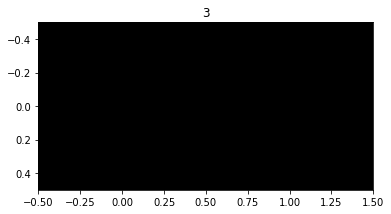

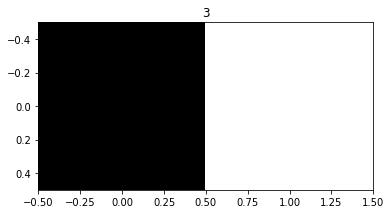

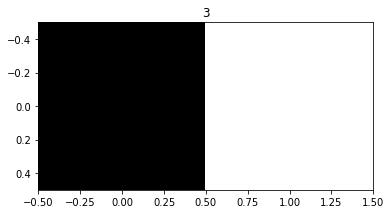

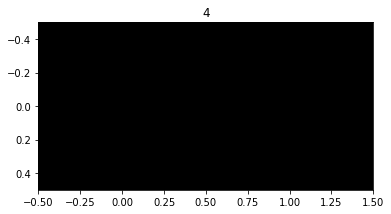

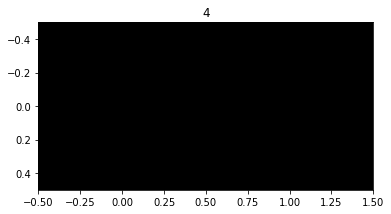

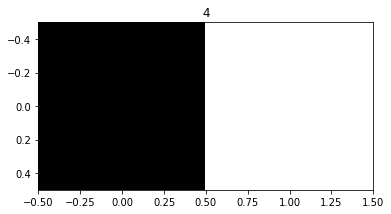

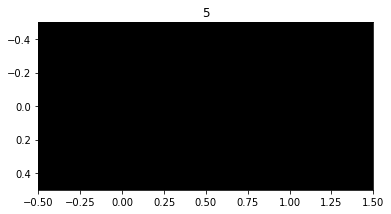

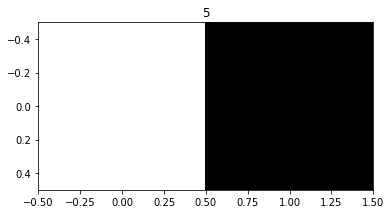

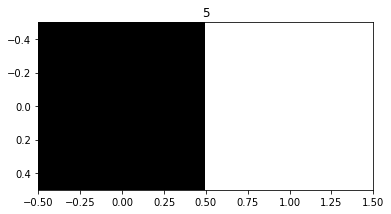

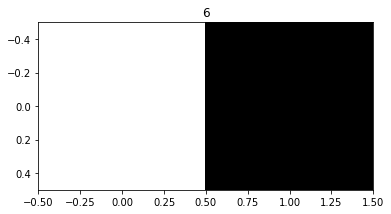

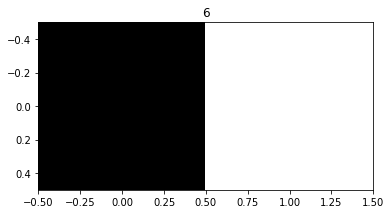

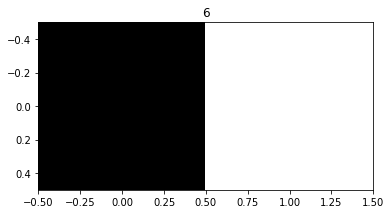

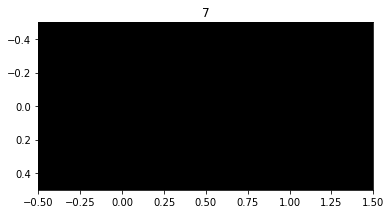

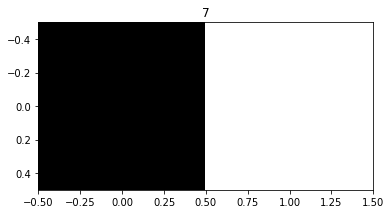

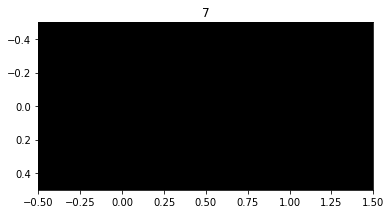

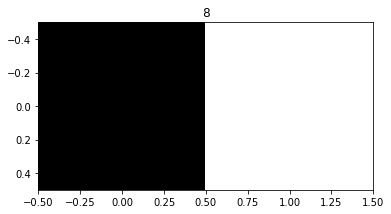

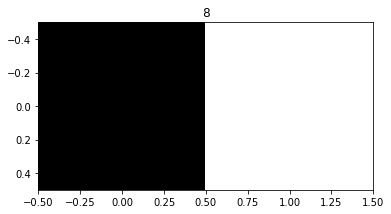

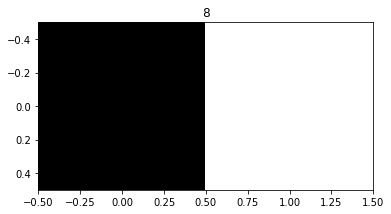

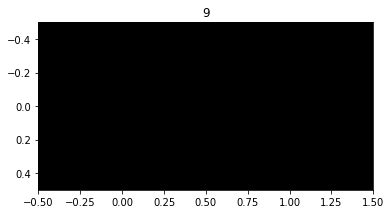

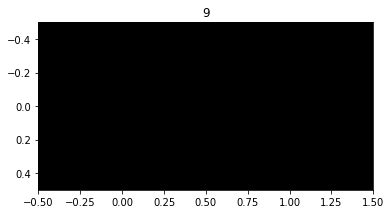

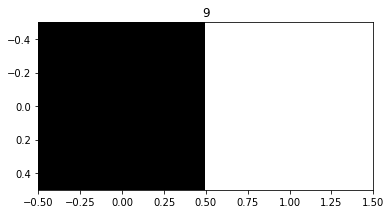

In [30]:
import matplotlib.pyplot as plt
count = 0
def plot(a, valor):
    plt.figure()
    plt.imshow(a[0], cmap='gray')
    plt.title('{}'.format(valor))

for n in range(10):
    count = 0
    for x,y in zip(x_test, y_test):
        if(y == n):
            count += 1
            predictions =  model2(x[None,:])
            #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
            plot(predictions.numpy().reshape([1,2,2]), y)
        if(count == 3):
            break


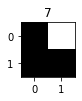

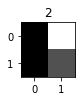

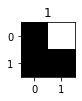

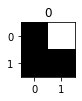

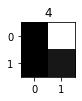

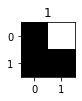

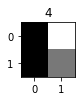

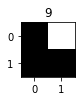

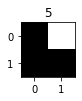

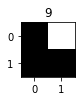

ate aqui


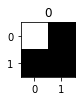

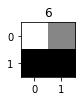

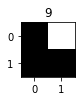

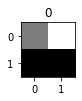

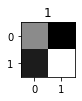

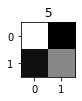

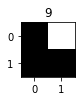

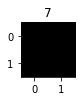

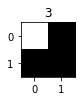

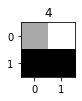

In [13]:
import matplotlib.pyplot as plt
count = 0
def plot(a, valor):
    plt.figure(figsize=(1,1))
    plt.imshow(a[0], cmap='gray')
    plt.title('{}'.format(valor))

for n in range(20):
    x = x_test[n]
    y = y_test[n]
    predictions =  model2(x[None,:])
    #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
    plot(predictions.numpy().reshape([1,2,2]), y)
    plt.show()
    if(n == 9):
        print('ate aqui')


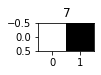

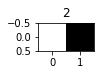

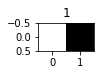

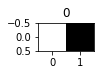

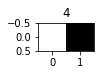

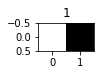

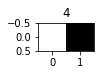

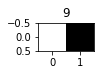

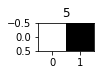

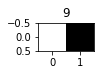

ate aqui


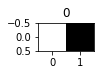

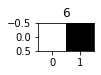

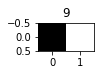

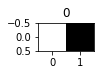

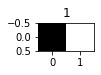

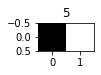

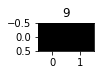

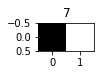

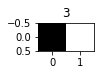

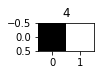

In [82]:
import matplotlib.pyplot as plt
count = 0
data = {'x': [], 'y': []}
def plot(a, valor):
    plt.figure(figsize=(1,1))
    plt.imshow(a[0], cmap='gray')
    plt.title('{}'.format(valor))

for n in range(20):
    x = x_test[n]
    y = y_test[n]
    predictions =  model2(x[None,:])
    #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
    plot(predictions.numpy().reshape([1,1,2]), y)
    data['x'].append(predictions.numpy().reshape([2])[0])
    data['y'].append(predictions.numpy().reshape([2])[1])
    plt.show()
    if(n == 9):
        print('ate aqui')


In [48]:
print(predictions2)

tf.Tensor([[-5.146 -2.769 -1.198 -4.299  8.169 -4.794 -5.495 -0.065  0.037  3.702]], shape=(1, 10), dtype=float32)


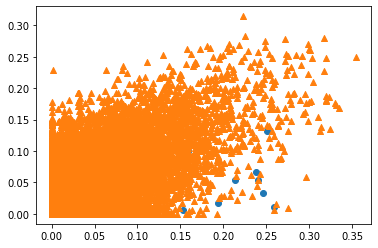

In [88]:
data = {'x': [], 'y': []}
for x,y in zip(x_test, y_test):
    predictions =  model2(x[None,:])
    #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
    data['x'].append(predictions.numpy().reshape([2])[0])
    data['y'].append(predictions.numpy().reshape([2])[1])
    plt.show()
    if(n == 9):
        print('ate aqui')



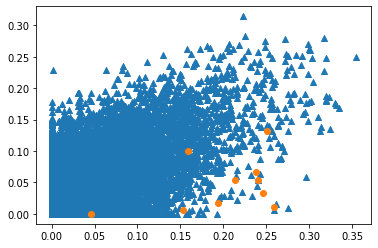

In [89]:

def plotar_xy(data):
    plt.scatter(data['x'][10:], data['y'][10:], marker='^')
    plt.scatter(data['x'][0:10], data['y'][0:10])

plotar_xy(data)
#print(data)

0.0 0.0


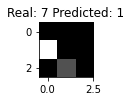

0.0 0.0076491013


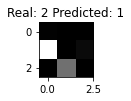

0.0 0.0


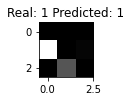

0.0 0.0


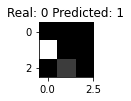

0.0 0.036217336


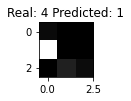

0.0 0.0


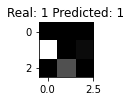

0.0 0.0


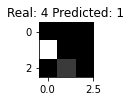

0.0 0.007288404


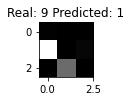

0.0 0.0


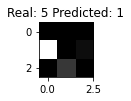

0.0 0.0


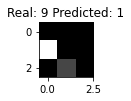

ate aqui
0.0 0.016835455


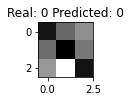

0.06754169 0.011966977


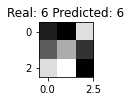

0.0 0.06528055


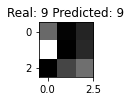

0.0 0.12230919


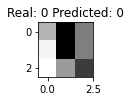

0.0 0.107744664


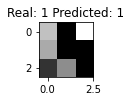

0.048206143 0.02226573


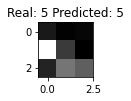

0.0 0.010009384


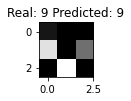

0.0 0.057430327


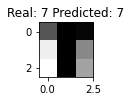

0.0 0.0


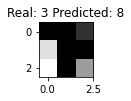

0.0025047744 0.0133208325


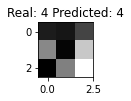

In [58]:
import matplotlib.pyplot as plt
count = 0
def plot(a, valor):
    plt.figure(figsize=(1,1))
    plt.imshow(a[0], cmap='gray')
    plt.title('{}'.format(valor))

for n in range(20):
    x = x_test[n]
    y = y_test[n]
    predictions_aux =  model2(x[None,:])
    predictions_final =  model([x[None,:], predictions_aux])
    #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
    print(predictions_aux.numpy().reshape([9])[4], predictions_aux.numpy().reshape([9])[0])
    plot(predictions_aux.numpy().reshape([1,3,3]), 'Real: ' + str(y) + ' Predicted: ' + str(np.argmax(predictions_final.numpy())))
    plt.show()
    if(n == 9):
        print('ate aqui')


In [49]:
data = {'x': [], 'y': []}
for x,y in zip(x_test, y_test):
    predictions =  model2(x[None,:])
    #print(tf.math.reduce_mean(predictions, axis=[-1]).numpy())
    data['x'].append(predictions.numpy().reshape([9])[7])
    data['y'].append(predictions.numpy().reshape([9])[8])
    #plt.show()
    #if(n == 9):
    #    print('ate aqui')



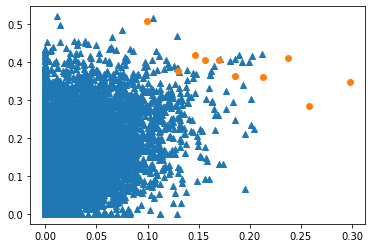

In [50]:

def plotar_xy(data):
    plt.scatter(data['x'][10:], data['y'][10:], marker='^')
    plt.scatter(data['x'][0:10], data['y'][0:10])
    #plt.axis([0, 0.02, 0, 0.02])

plotar_xy(data)
#print(data)